In [ ]:
!pip install tensorflow
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


ATTRIBUTES = ['antagonize' , 'condescending', 'dismissive', 'generalisation',
    'hostile', 'sarcastic', 'unhealthy'] #the goal is to detect unhealthy comments, so we will use the unhealthy attribute
HEALTHY_SAMPLE = 11500
TOKENIZER = Tokenizer(
    oov_token='<UNK>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False
)
NUM_EPOCHS = 21
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 16

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
ATTRIBUTES_MERGED = ['antagonize' , 'condescending', 'dismissive', 'generalisation',
    'hostile', 'sarcastic', 'unhealthy', 'healthy']

In [ ]:
#balance training data by removing healthy labels without hurting other attributes
def preprocess_train(train_data):
  healthy_symptomatic = train_data[
      (train_data['healthy'] == 1) &
      (train_data[attributes].sum(axis=1) > 1)
  ]

  healthy_clean = train_data[
      (train_data['healthy'] == 1) &
      (train_data[attributes].sum(axis=1) == 1)
  ]

  unhealthy = train_data[train_data['healthy'] == 0]

  sample_size = len(unhealthy) - len(healthy_symptomatic) + HEALTHY_SAMPLE #need more healthy samples to reflect distribution

  healthy_clean = healthy_clean.sample(n=sample_size, random_state=42)

  balanced_train_data = pd.concat([healthy_symptomatic, healthy_clean, unhealthy])

  #shuffle the dataset
  balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

  #add additional unhealthy label for comparitive purposes: https://github.com/conversationai/unhealthy-conversations?tab=readme-ov-file
  balanced_train_data['unhealthy'] = 1 - balanced_train_data['healthy']

  balanced_train_data[ATTRIBUTES_MERGED].sum().plot(kind='bar')
  plt.title('Training Samples per Attribute After Preprocessing')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  return balanced_train_data

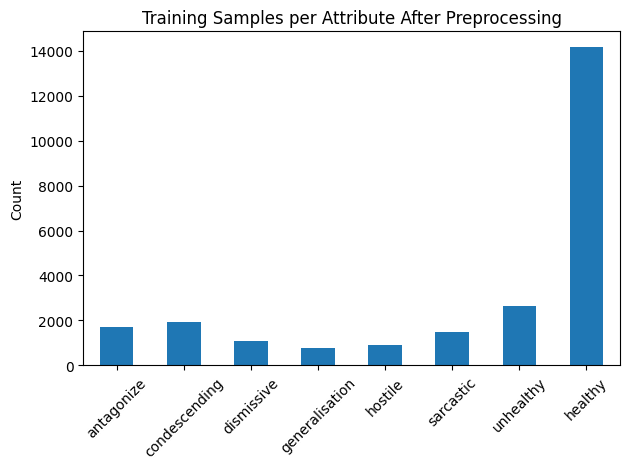

In [ ]:
attributes = [
    'antagonize' , 'condescending', 'dismissive', 'generalisation',
    'hostile', 'sarcastic', 'healthy']
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
val_data = pd.read_csv('data/val.csv')

balanced_train_data = preprocess_train(train_data)

In [ ]:
class UCC_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, max_length=512, vocab_size=10000, fit_tokenizer=True):
        self.data = data.copy()
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.tokenizer = TOKENIZER
        self.attributes = ATTRIBUTES

        # Extract texts and labels
        self.texts = data['comment'].astype(str).tolist()
        self.labels = data[self.attributes].values.astype(np.float32)

        #fit_tokenizer should be set to True during training and False otherwise
        if fit_tokenizer:
            self._fit_tokenizer()

        # Tokenize all texts
        self.tokenized_texts = self._tokenize_texts()

    def _fit_tokenizer(self):
        self.tokenizer.num_words = self.vocab_size
        self.tokenizer.fit_on_texts(self.texts)

    def _tokenize_texts(self):
        # Convert texts to sequences
        sequences = self.tokenizer.texts_to_sequences(self.texts)

        # Pad sequences to max_length
        padded_sequences = pad_sequences(
            sequences,
            maxlen=self.max_length,
            padding='post',
            truncating='post',
            value=0  # padding value
        )

        return padded_sequences

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get tokenized text
        input_ids = torch.tensor(self.tokenized_texts[idx], dtype=torch.long)

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = (input_ids != 0).long()

        # Get labels
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
        }

In [ ]:
def load_data(train_data, val_data, test_data, batch_size):
  # Add the 'unhealthy' column to val_data
  val_data['unhealthy'] = 1 - val_data['healthy']
  test_data['unhealthy'] = 1 - test_data['healthy']

  train_ds = UCC_Dataset(train_data)
  val_ds = UCC_Dataset(val_data, fit_tokenizer=False)
  test_ds = UCC_Dataset(test_data, fit_tokenizer=False)

  train_loader = torch.utils.data.DataLoader(
      dataset=train_ds,
      batch_size=batch_size,
      num_workers=2,
      pin_memory=True,
      shuffle=True
  )

  test_loader = torch.utils.data.DataLoader(
      dataset=test_ds,
      batch_size=batch_size,
      num_workers=2,
      pin_memory=True,
      shuffle=False
  )

  val_loader = torch.utils.data.DataLoader(
      dataset=val_ds,
      batch_size=batch_size,
      num_workers=2,
      pin_memory=True,
      shuffle=False
  )

  return train_ds, val_ds, train_loader, val_loader, test_loader

In [ ]:
GLOVE_DIR = './glove.6B'

# Download GloVe embeddings
if not os.path.exists(GLOVE_DIR):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    os.makedirs(GLOVE_DIR, exist_ok=True)
    !rm glove.6B.zip
    # Move files to the target directory
    for file_name in os.listdir('.'):
        if file_name.startswith('glove.6B.'):
            os.rename(file_name, os.path.join(GLOVE_DIR, file_name))

--2025-07-12 23:11:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-12 23:11:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-12 23:11:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # alternative approach - learned positional embeddings:
        self.positional_embeddings = nn.Parameter(0.02 * torch.randn(1, max_len, num_hiddens))

    def forward(self, X):
        # if using learned embeddings:
        X = X + self.positional_embeddings[:, :X.shape[1]]  # [bs, seq_len, embed_dim]
        return self.dropout(X)

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, dropout=0):
        super().__init__()
        self.dropout = dropout
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = PositionalEncoding(num_hiddens=d_model, dropout=self.dropout,
                                                      max_len=max_position_embeddings)
        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)
        self.d_model = d_model

    def forward(self, input_ids):
        seq_length = input_ids.size(1)

        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        # Get position embeddings for the word embeddings and add them
        embeddings = self.position_embeddings(word_embeddings) # (bs, max_seq_length, dim)

        # Layer norm
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_proj = nn.Linear(hidden_size, hidden_size)
        self.attention_v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output, mask=None):
        """
        lstm_output: (batch_size, seq_len, hidden_size)
        mask: (batch_size, seq_len), 1 for valid tokens, 0 for padding (optional)
        """
        proj = torch.tanh(self.attention_proj(lstm_output))  # (batch, seq_len, hidden_size)

        scores = self.attention_v(proj).squeeze(-1)  # (batch, seq_len)

        if mask is not None:
            # Ensure the mask has the same shape as the scores before masking
            mask = mask[:, :scores.size(1)]
            scores = scores.masked_fill(mask == 0, -1e9)  # Mask padding tokens

        # Normalize scores to attention weights
        attention_weights = F.softmax(scores, dim=1)  # (batch, seq_len)

        context = torch.bmm(attention_weights.unsqueeze(1), lstm_output)  # (batch, 1, hidden_size)
        context = context.squeeze(1)  # (batch, hidden_size)

        return context, attention_weights

In [ ]:
def getEmbeddingMatrix(): # Create a GloVe embedding matrix, dim = 200
  embeddings_index = {}
  with open(os.path.join(GLOVE_DIR, f'glove.6B.200d.txt'), encoding='utf-8') as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs
  word_index = TOKENIZER.word_index
  num_words = len(word_index) + 1
  embedding_matrix = np.zeros((num_words, 200))
  for word, i in word_index.items():
      if i > num_words:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

  print(f'Shape of embedding matrix: {embedding_matrix.shape}')

  # Convert the numpy embedding matrix to a PyTorch tensor
  return torch.from_numpy(embedding_matrix).float()

In [ ]:
import torch
import torch.nn as nn

class UCC_classifier(nn.Module):
    def __init__(self, embedding_dim=200, hidden_dim=256, num_layers=1, dropout=0.3, num_classes=7):
        super(UCC_classifier, self).__init__()
        embedding_matrix = getEmbeddingMatrix()
        # Use pre-trained GloVe embeddings
        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)

        # Convolutional layer before LSTM
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)

        )

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.concat_dim = 2 * hidden_dim

        # Attention layer
        self.attention = AttentionLayer(self.concat_dim)

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(self.concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Weight initialization
        nn.init.xavier_uniform_(self.classifier[0].weight)
        nn.init.xavier_uniform_(self.classifier[3].weight)
        nn.init.xavier_uniform_(self.classifier[-1].weight)

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.size()

        # Embedding
        embedded = self.embeddings(input_ids)  # (batch_size, seq_len, embedding_dim)

        # Conv1d expects (batch_size, in_channels, seq_len)
        conv_input = embedded.transpose(1, 2)  # (batch_size, embedding_dim, seq_len)
        conv_output = self.conv(conv_input)    # (batch_size, embedding_dim, seq_len//2)
        conv_output = conv_output.transpose(1, 2)  # (batch_size, seq_len//2, embedding_dim)

        # Handle optional attention mask for packed sequence
        if attention_mask is not None:
            # Downsample attention mask to match conv-pooled length
            pooled_seq_len = conv_output.size(1)
            attention_mask = attention_mask[:, :pooled_seq_len]
            lengths = attention_mask.sum(dim=1).cpu()
            valid_indices = lengths > 0
            if torch.sum(valid_indices) > 0:
                embedded_packed = nn.utils.rnn.pack_padded_sequence(
                    conv_output[valid_indices], lengths[valid_indices], batch_first=True, enforce_sorted=False
                )
                lstm_output_packed, _ = self.lstm(embedded_packed)
                lstm_output_unpacked, unpacked_lengths = nn.utils.rnn.pad_packed_sequence(
                    lstm_output_packed, batch_first=True
                )
                lstm_output = torch.zeros(batch_size, unpacked_lengths.max(), self.concat_dim, device=conv_output.device)
                lstm_output[valid_indices, :unpacked_lengths.max()] = lstm_output_unpacked
                seq_len = unpacked_lengths.max()
            else:
                lstm_output = torch.zeros(batch_size, 1, self.concat_dim, device=conv_output.device)
                seq_len = 1
        else:
            lstm_output, _ = self.lstm(conv_output)

        # Attention mask resize
        if attention_mask is not None:
            new_mask = torch.zeros(batch_size, seq_len, device=attention_mask.device)
            if torch.sum(valid_indices) > 0:
                for i, length in zip(torch.where(valid_indices)[0], unpacked_lengths):
                    new_mask[i, :length] = 1
            attention_mask = new_mask.unsqueeze(-1)

        # Attention
        context_vector, _ = self.attention(lstm_output, attention_mask.squeeze(-1) if attention_mask is not None else None)

        # Classifier
        logits = self.classifier(context_vector)

        return logits

In [ ]:
# calculate the model size on disk
dummy_model = UCC_classifier()
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
param_size = 0
for param in dummy_model.parameters():
  param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in dummy_model.buffers():
  buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024 ** 2
print(f"model size: {size_all_mb:.2f} MB")

Shape of embedding matrix: (1, 200)
model size: 5.67 MB


In [ ]:
def evaluate_model(model, val_loader, criterion, device):
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for batch_data in val_loader:
          comments = batch_data['input_ids'].to(device)
          attention_mask = batch_data['attention_mask'].to(device)
          attributes = batch_data['labels'].to(device)

          outputs = model(comments, attention_mask)
          loss = criterion(outputs, attributes)
          val_loss += loss.item() * comments.size(0)

  val_loss /= len(val_loader.dataset)
  return val_loss

SyntaxError: incomplete input (ipython-input-15-174153151.py, line 16)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs = NUM_EPOCHS):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  train_loss_per_epoch = []
  val_loss_per_epoch = []

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

  scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.20,
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=100
  )
  '''
  scheduler = get_cosine_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0.2 * num_epochs * len(train_loader),
      num_training_steps=num_epochs * len(train_loader)
  )
  '''

  # Early stopping parameters
  best_val_loss = float('inf')
  best_auc = 0.0
  patience = 10
  patience_counter = 0
  completed_epochs = 0 # Track the number of completed epochs

  # Gradient clipping
  clipping_value = 0.1 #values to check: [0.01, 0.05, 0.1, 0.5, 1.0]

  # training loop
  for epoch in range(1, num_epochs + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for batch_data in train_loader:
          inputs = batch_data['input_ids'].to(device)
          attention_mask = batch_data['attention_mask'].to(device)
          labels = batch_data['labels'].to(device)
          # forward + backward + optimize
          outputs = model(inputs, attention_mask)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
          optimizer.step()  # update parameters
          scheduler.step()  # placed here because we are using OneCycleLR

          running_loss += loss.data.item()

      # Normalizing the loss by the total number of train batches
      running_loss /= len(train_loader)
      train_loss_per_epoch.append(running_loss)

      val_loss = evaluate_model(model, val_loader, criterion, device)

      val_loss_per_epoch.append(val_loss)

      completed_epochs = epoch # Update completed_epochs

      model.eval()
      predictions = []
      model.to(device)

      with torch.no_grad():
          for batch_data in test_loader:
              comments = batch_data['input_ids'].to(device)
              attention_mask = batch_data['attention_mask'].to(device)
              outputs = model(comments, attention_mask)
              predictions.extend(outputs.cpu().numpy())

      predictions = np.array(predictions)
      labels = np.array(test_data[ATTRIBUTES])

      # Calculate AUC for each attribute and then the average
      from sklearn import metrics
      auc_scores = []
      for i in range(len(ATTRIBUTES)):
          try:
              auc = metrics.roc_auc_score(labels[:, i].astype(int), predictions[:, i])
              auc_scores.append(auc)
          except ValueError:
              # Handle cases where there's only one class in the labels
              print(f"Could not calculate AUC for attribute {ATTRIBUTES[i]}")
              pass

      average_auc = np.mean(auc_scores) if auc_scores else 0

      if average_auc > best_auc:
          best_auc = average_auc
          torch.save(model, 'best_model.pth') # Save the entire model
          torch.save(model.state_dict(), 'best_model_dict.pth')
          patience_counter = 0

      else:
          patience_counter += 1

      if patience_counter >= patience:
          print("Early stopping triggered. Training stopped.")
          break

      log = "Epoch: {} | Train Loss: {:.4f} | Val Loss: {:.4f} | ".format(epoch, running_loss, val_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)


  print('==> Finished Training ...')

  # Plotting Loss
  plt.figure(figsize=(8, 5))
  # Use the actual number of completed epochs for the x-axis
  plt.plot(range(1, completed_epochs + 1), train_loss_per_epoch, label='Train Loss')
  plt.plot(range(1, completed_epochs + 1), val_loss_per_epoch, label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
train_ds, val_ds, train_loader, val_loader, test_loader = load_data(balanced_train_data, val_data, test_data, BATCH_SIZE)
model = UCC_classifier()
train_model(model, train_loader, val_loader)

In [ ]:
labels = np.array(test_data[ATTRIBUTES])
# Load the best model state dictionary
model = UCC_classifier()
model = torch.load('best_model.pth', weights_only = False)

# Set the model to evaluation mode
model.eval()

predictions = []
model.to(device)

with torch.no_grad():
    for batch_data in test_loader:
        comments = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)

        outputs = model(comments, attention_mask)
        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions)

from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(ATTRIBUTES):
  fpr, tpr, _ = metrics.roc_curve(
      labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.title("BiLSTM + Attention\nROC-AUC Score on Test Set", fontsize=14, fontweight='bold')

In [ ]:
#it's important that the model saved is the *entire* model, not just the state dict
#(this is because of fine-tuned word embeddings which aren't in the weights)
def evaluated_saved_model(model_path):
    labels = np.array(test_data[ATTRIBUTES])
    # Load the best model state dictionary
    model = UCC_classifier()
    model = torch.load(model_path, weights_only = False)

    # Set the model to evaluation mode
    model.eval()

    predictions = []
    model.to(device)

    with torch.no_grad():
        for batch_data in test_loader:
            comments = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)

            outputs = model(comments, attention_mask)
            predictions.extend(outputs.cpu().numpy())

    predictions = np.array(predictions)

    from sklearn import metrics
    plt.figure(figsize=(15, 8))
    for i, attribute in enumerate(ATTRIBUTES):
      fpr, tpr, _ = metrics.roc_curve(
          labels[:,i].astype(int), predictions[:, i])
      auc = metrics.roc_auc_score(
          labels[:,i].astype(int), predictions[:, i])
      plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right')
    plt.title("BiLSTM + Attention\nROC-AUC Score on Test Set", fontsize=14, fontweight='bold')